# Imports

In [1]:
import pandas as pd
from sklearn.decomposition import PCA

# Read data

In [2]:
df = pd.read_csv("data/s2.csv", skiprows=1, sep=';', index_col=0)
criteria_types = [t.strip() for t in open('data/s2.csv', 'r').readline().split(';') if t]
print(criteria_types)
df

['cost', 'cost', 'cost', 'gain', 'gain']


,g1,g2,g3,g4,g5
a01,18342,30.7,37.2,2.33,3.00
a02,15335,30.2,41.6,2.00,2.50
a03,16973,29.0,34.9,2.66,2.50
a04,15460,30.4,35.8,1.66,1.50
a05,15131,29.7,35.6,1.66,1.75
a06,13841,30.8,36.5,1.33,2.00
a07,18971,28.0,35.6,2.33,2.00
a08,18319,28.9,35.3,1.66,2.00
a09,19800,29.4,34.7,2.00,1.75
a10,16966,30.0,37.7,2.33,3.25


In [3]:
PREFERENCES = [
    ('a08', 'a09')
]

In [4]:
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, GLPK

In [8]:
NECESSARY = 1
POSSIBLE = 2

def uta_gms(df: pd.DataFrame) -> pd.DataFrame:
    

alternatives = df.index
df_relations = pd.DataFrame(0, index=alternatives, columns=alternatives)
for alt_1_id in alternatives:
    for alt_2_id in alternatives:
        if alt_1_id == alt_2_id:
            df_relations.loc[alt_1_id, alt_2_id] = NECESSARY
            continue

        # Badanie relacji koniecznej alt_1 > alt_2
        problem = LpProblem("uta-gms", LpMaximize)
        epsilon = LpVariable("epsilon")
        decision_variables = {}
        for column in df.columns:
            unique_values = df[column].sort_values().unique()
            decision_variables[column] = [LpVariable(f"x_{column}_{value}", 0, 1) for value in unique_values]
        problem += lpSum([x[0] for x in decision_variables.values()]) == 1
        problem += lpSum([x[-1] for x in decision_variables.values()]) == 0
        for column in df.columns:
            for i in range(len(decision_variables[column])-1):
                problem += decision_variables[column][i] >= decision_variables[column][i+1]
        for preference in PREFERENCES:
            alt_1 = df.loc[preference[0]].to_dict()
            alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
            alt_2 = df.loc[preference[1]].to_dict()
            alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]
            problem += lpSum(alt_1_variables) >= lpSum(alt_2_variables) + epsilon
        # Dodanie preferencji badającej relację konieczną
        alt_1 = df.loc[alt_1_id].to_dict()
        alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
        alt_2 = df.loc[alt_2_id].to_dict()
        alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]
        problem += lpSum(alt_2_variables) >= lpSum(alt_1_variables) + epsilon
        problem += epsilon
        problem.solve(solver=GLPK(msg=False))
        solution = {variable.name: variable.varValue for variable in problem.variables()}
        epsilon_value = solution['epsilon']
        if epsilon_value <= 0:
            df_relations.loc[alt_1_id, alt_2_id] = NECESSARY
            continue
        
        # Badanie relacji możliwej alt_1 > alt_2
        problem = LpProblem("uta-gms", LpMaximize)
        epsilon = LpVariable("epsilon")
        decision_variables = {}
        for column in df.columns:
            unique_values = df[column].sort_values().unique()
            decision_variables[column] = [LpVariable(f"x_{column}_{value}", 0, 1) for value in unique_values]
        problem += lpSum([x[0] for x in decision_variables.values()]) == 1
        problem += lpSum([x[-1] for x in decision_variables.values()]) == 0
        for column in df.columns:
            for i in range(len(decision_variables[column])-1):
                problem += decision_variables[column][i] >= decision_variables[column][i+1]
        for preference in PREFERENCES:
            alt_1 = df.loc[preference[0]].to_dict()
            alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
            alt_2 = df.loc[preference[1]].to_dict()
            alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]
            problem += lpSum(alt_1_variables) >= lpSum(alt_2_variables) + epsilon
        # Dodanie preferencji badającej relację możliwą
        alt_1 = df.loc[alt_1_id].to_dict()
        alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
        alt_2 = df.loc[alt_2_id].to_dict()
        alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]
        problem += lpSum(alt_1_variables) >= lpSum(alt_2_variables)
        problem += epsilon
        problem.solve(solver=GLPK(msg=False))
        solution = {variable.name: variable.varValue for variable in problem.variables()}
        epsilon_value = solution['epsilon']
        if epsilon_value > 0:
            df_relations.loc[alt_1_id, alt_2_id] = POSSIBLE

    return df_relations

In [10]:
df_relations = df_relations[df_relations == 1].fillna(0)
df_relations

,a01,a02,a03,a04,a05,a06,a07,a08,a09,a10,a11,a12,a13,a14
a01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a04,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a05,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
a06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a07,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
a08,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
a09,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
a10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


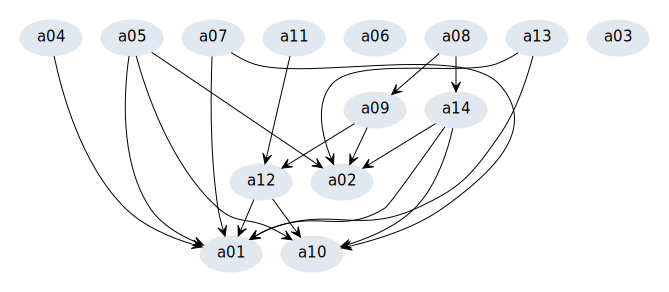

In [11]:
from hassediagram.hasse_diagram import hasse_graphviz
hasse_graphviz(df_relations.values, df.index)